# [Wasserstein Divergence for GANs](https://arxiv.org/abs/1712.01026)

In [1]:
import argparse
import os
import numpy as np
import math
import sys

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

from matplotlib import pyplot

In [2]:
# Define some parameters
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=201, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=40, help="interval betwen image samples")
opt, unknown = parser.parse_known_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


Namespace(b1=0.5, b2=0.999, batch_size=64, channels=1, clip_value=0.01, img_size=28, latent_dim=100, lr=0.0002, n_cpu=8, n_critic=5, n_epochs=201, sample_interval=40)


## Define the Generator and Discriminator
- For the Generator, the input is a vector of length `opt.latent_dim`, the output is image matrix of size `img_shape` with value curved by `nn.Tanh()`, i.e. between [-1,1]. In each layer, we have normalization and LeakyReLU activation
- For the Discriminator, the input is matrix of size `img_shape`, the output is a scalar. In each layer, we have normalization followed by LeakyReLU activation
- Then initialize the Generator and Discriminator on GPU devices

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    #generator = nn.DataParallel(generator)
    generator.cuda()
    #discriminator = nn.DataParallel(discriminator)
    discriminator.cuda()


## Download data and initialize a DataLoader with batch_size = opt.batch_size

In [4]:
# Download data and initialize a DataLoader with batch_size = opt.batch_size
os.makedirs("data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)


In [5]:
# Define the optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [6]:
# Define function to plot results
%matplotlib inline
def show(img):
    npimg = img.cpu().numpy()
    pyplot.imshow(np.transpose(npimg, (1,2,0)))


## Training
 - For a given Generator, train the Discriminator by
    1. Clear optimizer by `optimizer_D.zero_grad()`
    2. Generate a batch (n=imgs.shape[0]) of noise and feed it to Generator to generate a batch of fake images `fake_imgs` 
    3. Calculate Wasserstein divergence gradient penalty by feed Discriminator a batch of `real_imgs` and a batch of same number of `fake_imgs`. Then calculate the `div_gp`
    4. Calculate adversarial loss by `d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp`
    5. Calculate the gradient of loss on weights by `d_loss.backward()`
    6. Adjust parameters based on gradients by `optimizer_D.step()`
 - For a fixed Discriminator, for every `opt.n_critic` steps, train the Generator by
    1. Clear optimizer by `optimizer_G.zero_grad()`
    2. Generate a batch of images `fake_imgs = generator(z)`
    3. Calculate Loss measures generator's ability to fool the discriminator `fake_validity = discriminator(fake_imgs)`, followed by `g_loss = -torch.mean(fake_validity)`
    4. Calculate gradient `g_loss.backward()`
    5. Adjust parameters based on gradients `optimizer_G.step()`


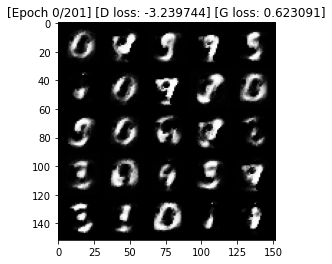

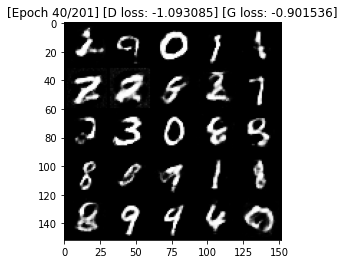

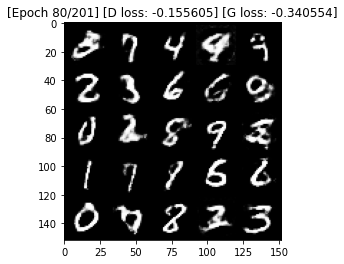

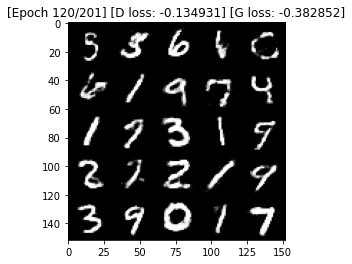

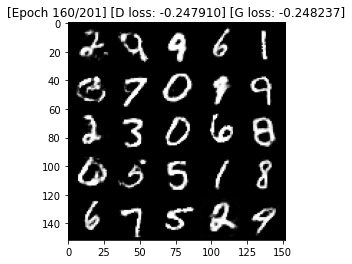

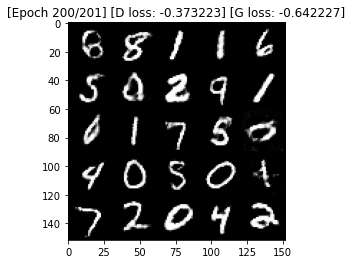

In [7]:
# Trainig
k = 2
p = 6

# Define data type in tensor
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

batches_done = 0
for epoch in range(opt.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor), requires_grad=True)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Clear optimizer for discriminator
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)

        # Compute W-div gradient penalty
        real_grad_out = Variable(Tensor(real_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        real_grad = autograd.grad(
            real_validity, real_imgs, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        fake_grad_out = Variable(Tensor(fake_imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake_grad = autograd.grad(
            fake_validity, fake_imgs, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
        )[0]
        fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

        div_gp = torch.mean(real_grad_norm + fake_grad_norm) * k / 2

        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + div_gp
        ## Calculate gradient
        d_loss.backward()
        ## Adjust parameters based on gradients
        optimizer_D.step()

        # Train the generator every n_critic steps
        ## Clear optimizer for generator
        optimizer_G.zero_grad()
        if i % opt.n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)

            # loss
            g_loss = -torch.mean(fake_validity)
            ## Calculate gradient
            g_loss.backward()
            ## Adjust parameters based on gradients
            optimizer_G.step()

            batches_done += opt.n_critic

    if epoch % opt.sample_interval == 0:
        pyplot.figure()
        show(make_grid(fake_imgs.data[:25], nrow = 5, normalize=True))
        pyplot.title(
            "[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, opt.n_epochs, d_loss.item(), g_loss.item())
        )
        pyplot.show()


We have trained the Generator and Discriminator for 200 epochs, For every 40 epochs, we drawed 25 fake images of handwritten digits with Discriminator and Generator loss. We can see that after Epoch=100, as the generator and discriminator competing to each other, the generated fake images were much closer to pictures in dataset.

Python Note:
- `super()` function in `class` can be used to applying method defined in its super class. It is useful for multiple inherits. In the code, we don't have to specify the current class, i.e. we can write `super().__init__()` instead of the specific form `super(Generator, self).__init__()`.

Torch Note:
- The code of dataloader and trainig can also be modified to distributed data parallel (DDP) by spawning the model to distributed GPUs. I may show it in final project after I solving the memory issue. Check [Pytorch Distributed Overview](https://pytorch.org/tutorials/beginner/dist_overview.html)
- It is not recommended to use `nn.DataParallel()` for generator and discriminator directly. I tried it but it actually slow down the trainig process. The official document says due to GIL(Global Interpreter Lock) of Python, multiprocessing on distributed GPUs is not efficient. 